In [35]:
class PointAttribute:
    def __init__(s, name, elements, bytes):
        s.name = name
        s.elements = elements
        s.bytes = bytes

class PointAttributes:
    POSITION_CARTESIAN = PointAttribute("POSITION_CARTESIAN", 3, 12)
    POSITION_PROJECTED_PROFILE = PointAttribute("POSITION_PROJECTED_PROFILE", 2, 8)
    COLOR_PACKED = PointAttribute("COLOR_PACKED", 4, 4)
    RGB = PointAttribute("RGB", 3, 3)
    RGBA = PointAttribute("RGBA", 4, 4)
    INTENSITY = PointAttribute("INTENSITY", 1, 2)
    CLASSIFICATION = PointAttribute("CLASSIFICATION", 1, 1)
    
    def __init__(s):
        s.attributes = []
        s.bytes = 0
        
    def add(s, attribute):
        s.attributes.append(attribute)
        s.bytes = s.bytes + attribute.bytes * attribute.elements
        
    @staticmethod
    def fromName(name):
        return getattr(PointAttributes, name)

In [41]:
import subprocess
import struct
import json
import sys
import time

exe = "D:/dev/workspaces/CPotree/master/bin/Release_x64/PotreeElevationProfile.exe"

file = "D:/dev/pointclouds/converted/CA13/cloud.js"
coordinates = "{693550.968, 3915914.169},{693890.618, 3916387.819},{694584.820, 3916458.180},{694786.239, 3916307.199}"
width = "14.0"
minLevel = "0"
maxLevel = "4"
attributes = [] # empty list: all available + POSITION_PROJECTED_PROFILE
#attributes = ["--output-attributes", "POSITION_CARTESIAN", POSITION_PROJECTED_PROFILE", "RGB]



start = time.time()
p = subprocess.Popen([exe, file, "--stdout"] + attributes + ["--coordinates", coordinates, "--width", width, "--min-level", minLevel, "--max-level", maxLevel], bufsize=-1, stdout=subprocess.PIPE)
[out, err] = p.communicate()
end = time.time()
print("duration: ", int(1000 * (end - start)), "ms")

headerSize = struct.unpack('i', out[0:4])[0];
header = out[4:4+headerSize].decode("ascii")
buffer = out[4+headerSize:]

print("header:")
print(header)

duration:  78 ms
header:
{
	"points": 9520,
	"pointsProcessed": 350278,
	"nodesProcessed": 28,
	"durationMS": 52,
	"boundingBox": {
		"lx": 693546.660000,
		"ly": 3915912.309250,
		"lz": -0.270000,
		"ux": 694789.538750,
		"uy": 3916464.499750,
		"uz": 171.120000
	},
	"pointAttributes": [
		"POSITION_CARTESIAN",
		"COLOR_PACKED",
		"INTENSITY",
		"CLASSIFICATION",
		"POSITION_PROJECTED_PROFILE"
	],
	"bytesPerPoint": 27,
	"scale": 0.001000
}



In [42]:
jHeader = json.loads(header)

numPoints = int(jHeader["points"])
scale = float(jHeader["scale"])
bytesPerPoint = int(jHeader["bytesPerPoint"])
#attributes = jHeader["pointAttributes"]

attributes = []
for attribute in jHeader["pointAttributes"]:
    attributes.append(PointAttributes.fromName(attribute))

lx = []
ly = []
lz = []
lpx = []
lpz = []
lc = []

for i in range(numPoints):
    byteOffset = bytesPerPoint * i
    pbuffer = buffer[byteOffset:byteOffset + bytesPerPoint]
    
    aoffset = 0
    for attribute in attributes:
        
        if attribute == PointAttributes.POSITION_CARTESIAN:
            ux = struct.unpack('i', pbuffer[aoffset + 0: aoffset + 4])[0]
            uy = struct.unpack('i', pbuffer[aoffset + 4: aoffset + 8])[0]
            uz = struct.unpack('i', pbuffer[aoffset + 8: aoffset + 12])[0]
            
            x = ux * scale
            y = uy * scale
            z = uz * scale
            
            lx.append(x)
            ly.append(y)
            lz.append(z)
        
        elif attribute == PointAttributes.POSITION_PROJECTED_PROFILE:
            ux = struct.unpack('i', pbuffer[aoffset + 0: aoffset + 4])[0]
            #uy = struct.unpack('i', pbuffer[aoffset + 4: aoffset + 8])[0]
            uz = struct.unpack('i', pbuffer[aoffset + 4: aoffset + 8])[0]
            
            x = ux * scale
            #y = uy * scale
            z = uz * scale
            
            lpx.append(x)
            #ly.append(y)
            lpz.append(z)
            
        elif attribute == PointAttributes.COLOR_PACKED:
            r = pbuffer[aoffset + 0] / 255
            g = pbuffer[aoffset + 1] / 255
            b = pbuffer[aoffset + 2] / 255
            
            lc.append([r, g, b, 1.0])
            
        elif attribute == PointAttributes.RGB:
            r = pbuffer[aoffset + 0] / 255
            g = pbuffer[aoffset + 1] / 255
            b = pbuffer[aoffset + 2] / 255
            
            lc.append([r, g, b, 1.0])
            
        elif attribute == PointAttributes.INTENSITY:
            
            i = struct.unpack('H', pbuffer[aoffset:aoffset+2])[0] / 255
            i = min(i, 1.0)
            
        elif attribute == PointAttributes.CLASSIFICATION:
            pass
            
        aoffset = aoffset + attribute.bytes
            

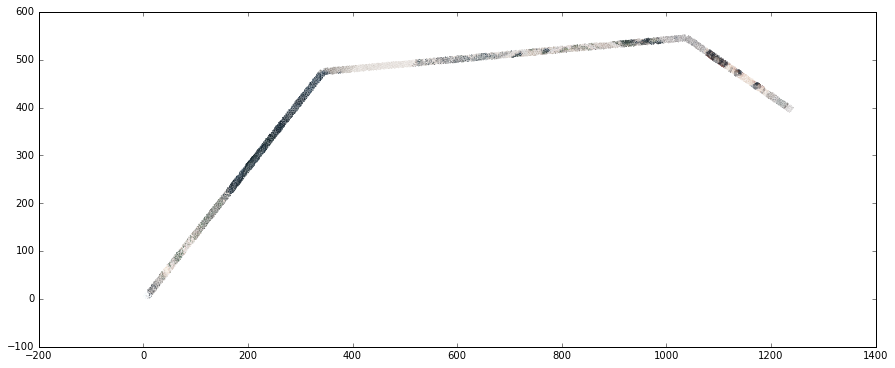

In [43]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


N = len(lx)
x = lx[:N]
y = ly[:N]
colors = lc[:N]

plt.figure(figsize=(15, 6))
plt.scatter(x, y, s=1, c=colors, edgecolors='none')
plt.show()

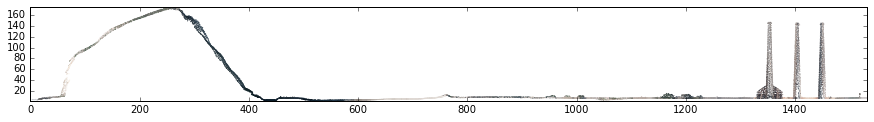

In [39]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


N = len(lpx)
x = lpx[:N]
y = lpz[:N]
colors = lc[:N]

plt.figure(figsize=(15, 6))
plt.axes().set_aspect('equal', 'box')
plt.scatter(x, y, s=1, c=colors, edgecolors='none')
plt.xlim([min(x), max(x)])
plt.ylim([min(y), max(y)])
#plt.ylim(-0.5, 4)
plt.show()

1532.3120000000001